In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

%matplotlib inline 

In [2]:
data_gs = pd.read_csv("../data/observations-gregtasney.csv")
data_gs.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_26292\3140657315.py:1: DtypeWarning: Columns (15,26,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data_gs = pd.read_csv("../data/observations-gregtasney.csv")


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,26102174,Sun May 26 2019 07:56:38 GMT+1000 (GMT+10),2019-05-26,2019-05-25 21:56:38 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:25:48 UTC,2019-06-02 04:59:50 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
1,26102183,Sun May 19 2019 10:45:52 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:45:52 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:15 UTC,2022-10-18 09:01:06 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Lesser Wanderer,Danaus petilia,Lesser Wanderer,Insecta,333775.0
2,26102189,Sun May 19 2019 10:37:34 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:37:34 UTC,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:36 UTC,2022-01-25 09:25:37 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Blue Wanderer,Tirumala hamata,Blue Wanderer,Insecta,197078.0
3,26102706,NaN,NaN,NaN,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:55:01 UTC,2023-04-27 13:22:35 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Burnie Vine,Malaisia scandens,Burnie Vine,Plantae,705655.0
4,26102759,2019/05/01 8:04 PM HST,2019-05-01,2019-05-02 06:04:00 UTC,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:57:25 UTC,2019-06-02 04:59:40 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0


## Short and Dirty clean-up for mockup

In [3]:
# missing lat before drop
data_gs[data_gs["latitude"].isnull()].shape[0]

306

In [4]:
#dropping missing lat/long with confirm
data_gs.dropna(subset=['latitude'], inplace=True)
print(f'Number of null lat entries = {data_gs[data_gs["latitude"].isnull()].shape[0]}',
f'\nNumber of null long entries = {data_gs[data_gs["longitude"].isnull()].shape[0]}')

Number of null lat entries = 0 
Number of null long entries = 0


In [5]:
# checking time_observed_at after above drop
data_gs[data_gs["time_observed_at"].isnull()].shape[0]

22

In [6]:
# dropping missing observed time rows and confirming
data_gs.dropna(subset=['time_observed_at'], inplace=True)
print(f'Number of null time_observed_at entries = {data_gs[data_gs["latitude"].isnull()].shape[0]}')

Number of null time_observed_at entries = 0


In [7]:
# rechecking type of data for time observed
data_gs["time_observed_at"].map(type).value_counts()

<class 'str'>    97289
Name: time_observed_at, dtype: int64

In [8]:
data_gs["time_observed_at"] = pd.to_datetime(data_gs["time_observed_at"])
data_gs.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,26102174,Sun May 26 2019 07:56:38 GMT+1000 (GMT+10),2019-05-26,2019-05-25 21:56:38+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:25:48 UTC,2019-06-02 04:59:50 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
1,26102183,Sun May 19 2019 10:45:52 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:45:52+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:15 UTC,2022-10-18 09:01:06 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Lesser Wanderer,Danaus petilia,Lesser Wanderer,Insecta,333775.0
2,26102189,Sun May 19 2019 10:37:34 GMT+1000 (GMT+10),2019-05-19,2019-05-19 00:37:34+00:00,Brisbane,1809954,gregtasney,Greg Tasney,2019-05-31 06:26:36 UTC,2022-01-25 09:25:37 UTC,...,Corinda,Queensland,Australia,Queensland,Corinda,Blue Wanderer,Tirumala hamata,Blue Wanderer,Insecta,197078.0
4,26102759,2019/05/01 8:04 PM HST,2019-05-01,2019-05-02 06:04:00+00:00,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 06:57:25 UTC,2019-06-02 04:59:40 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Argina astrea,Argina astrea,crotalaria pod borer,Insecta,318525.0
5,26102851,2019/04/28 9:28 AM HST,2019-04-28,2019-04-28 19:28:00+00:00,Hawaii,1809954,gregtasney,Greg Tasney,2019-05-31 07:01:49 UTC,2019-05-31 07:01:49 UTC,...,Salisbury,Queensland,Australia,Queensland,Salisbury,Poneridia semipullata,Poneridia semipullata,Figleaf Beetle,Insecta,520427.0


In [9]:
# checking type of data for time observed
data_gs["time_observed_at"].map(type).value_counts()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>    97289
Name: time_observed_at, dtype: int64

## Digging into Plantae data

In [10]:
# number of Plantae observations with positional accuracy 30m or less
data_gs[(data_gs["iconic_taxon_name"] == 'Plantae') & (data_gs["positional_accuracy"] <= 30)].shape[0]

16007

In [11]:
# count of unique Plant species
data_gs[(data_gs["iconic_taxon_name"] == 'Plantae') & (data_gs["positional_accuracy"] <= 30)]['scientific_name'].value_counts().sort_values()

Tetrarrhena juncea                  1
Drosera trichocaulis                1
Briza maxima                        1
Eleocharis dulcis                   1
Labichea lanceolata brevifolia      1
                                 ... 
Parsonsia straminea               196
Cryptocarya triplinervis          198
Eucalyptus tereticornis           201
Elaeocarpus obovatus              204
Streblus brunonianus              276
Name: scientific_name, Length: 2267, dtype: int64

# Focus mock up on single entry

In [12]:
data_gs[data_gs["scientific_name"] == "Tetrarrhena juncea"]

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,place_county_name,place_state_name,place_country_name,place_admin1_name,place_admin2_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
25690,82817104,2021/06/13 10:35 AM AEST,2021-06-13,2021-06-13 00:35:00+00:00,Sydney,1809954,gregtasney,Greg Tasney,2021-06-13 10:41:05 UTC,2021-06-13 11:16:42 UTC,...,Gatton,Queensland,Australia,Queensland,Gatton,Forest Wire-grass,Tetrarrhena juncea,Forest Wire-grass,Plantae,802793.0


In [149]:
# narrow focus to columns most useful to interpolation
subset = data_gs[['id', 'time_observed_at',
                   'latitude', 'longitude',
                   'positional_accuracy', 'scientific_name',
                   'iconic_taxon_name']]

In [150]:
# narrow focus to observations with good positional accuracy
# and near the Tetrarrhena juncea in time
# sorting by time
subset = subset[(subset['time_observed_at'] >= '2021-06-12') & \
                (subset['time_observed_at'] < '2021-06-15') & \
                (subset["positional_accuracy"] <= 30)].sort_values(by="time_observed_at").reset_index()
subset

,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name
0,25568,82647368,2021-06-12 01:42:28+00:00,-27.449142,152.974412,16.0,Threskiornis spinicollis,Aves
1,25557,82639661,2021-06-12 02:36:20+00:00,-27.315333,152.746413,28.0,Leichhardtia rostrata,Plantae
2,25556,82639645,2021-06-12 02:36:43+00:00,-27.315297,152.746338,25.0,Flagellaria indica,Plantae
3,25555,82639615,2021-06-12 02:36:47+00:00,-27.315308,152.746338,18.0,Sarcopteryx stipata,Plantae
4,25553,82639557,2021-06-12 02:37:18+00:00,-27.315263,152.746247,28.0,Arytera distylis,Plantae
...,...,...,...,...,...,...,...,...
226,25817,83105143,2021-06-14 10:50:00+00:00,-27.743467,152.939575,7.0,Melia azedarach,Plantae
227,25819,83105145,2021-06-14 10:50:00+00:00,-27.743469,152.939544,7.0,Mallotus philippensis,Plantae
228,25820,83105146,2021-06-14 10:51:00+00:00,-27.743575,152.939147,6.0,Amyema,Plantae
229,25821,83105147,2021-06-14 10:53:00+00:00,-27.743783,152.938308,15.0,Acacia irrorata,Plantae


In [151]:
# the min_from_beg for target prediction
TJ_time = subset.loc[subset["scientific_name"] == "Tetrarrhena juncea","time_observed_at"].iloc[0]
TJ_time

Timestamp('2021-06-13 00:35:00+0000', tz='UTC')

In [152]:
# creating time column where time is measured in minutes from the target datetime for TJ species
subset["sec_from_TJ"] = 0
for i in range(subset.shape[0]):
    sec_away = (subset["time_observed_at"][i] - TJ_time).total_seconds() 
    subset["sec_from_TJ"][i] = sec_away
subset

C:\Users\lisa_\AppData\Local\Temp\ipykernel_26292\865649831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["sec_from_TJ"][i] = sec_away


,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name,sec_from_TJ
0,25568,82647368,2021-06-12 01:42:28+00:00,-27.449142,152.974412,16.0,Threskiornis spinicollis,Aves,-82352
1,25557,82639661,2021-06-12 02:36:20+00:00,-27.315333,152.746413,28.0,Leichhardtia rostrata,Plantae,-79120
2,25556,82639645,2021-06-12 02:36:43+00:00,-27.315297,152.746338,25.0,Flagellaria indica,Plantae,-79097
3,25555,82639615,2021-06-12 02:36:47+00:00,-27.315308,152.746338,18.0,Sarcopteryx stipata,Plantae,-79093
4,25553,82639557,2021-06-12 02:37:18+00:00,-27.315263,152.746247,28.0,Arytera distylis,Plantae,-79062
...,...,...,...,...,...,...,...,...,...
226,25817,83105143,2021-06-14 10:50:00+00:00,-27.743467,152.939575,7.0,Melia azedarach,Plantae,123300
227,25819,83105145,2021-06-14 10:50:00+00:00,-27.743469,152.939544,7.0,Mallotus philippensis,Plantae,123300
228,25820,83105146,2021-06-14 10:51:00+00:00,-27.743575,152.939147,6.0,Amyema,Plantae,123360
229,25821,83105147,2021-06-14 10:53:00+00:00,-27.743783,152.938308,15.0,Acacia irrorata,Plantae,123480


In [153]:
#removing target TJ entry row to create model from remaining data
subset.drop(subset[subset["scientific_name"] == "Tetrarrhena juncea"].index, inplace = True)
subset.reset_index(inplace = True)

In [154]:
# double check
subset[subset["scientific_name"] == "Tetrarrhena juncea"]

,level_0,index,id,time_observed_at,latitude,longitude,positional_accuracy,scientific_name,iconic_taxon_name,sec_from_TJ


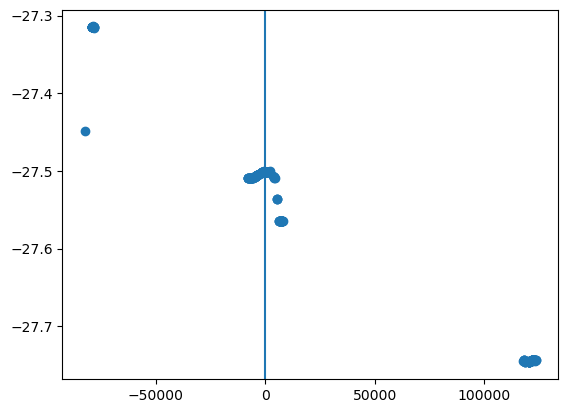

In [157]:
plt.figure()
plt.scatter(subset["sec_from_TJ"], subset["latitude"])
plt.axvline(x = 0)
plt.show()

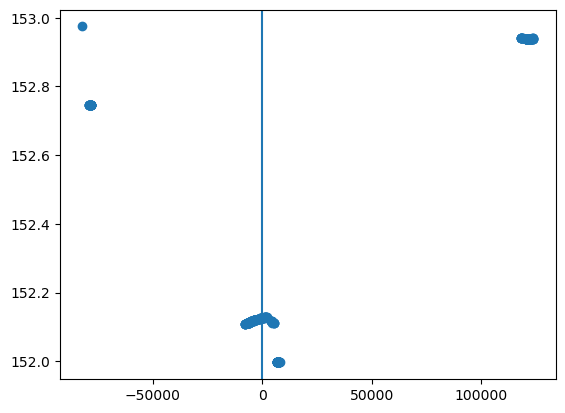

In [158]:
plt.figure()
plt.scatter(subset["sec_from_TJ"], subset["longitude"])
plt.axvline(x = 0)
plt.show()

## Code for models

In [183]:
# Creates empty dictionary for comparison of prediction models
model_predictions = {}

In [224]:
# creates list of indices above and below target value given number of datapoints we want above 
# with presumption of number of above = number below
index_above_target = subset[subset["sec_from_TJ"] > 0]["sec_from_TJ"].idxmin()
how_many_above = 4
desired_indices = [index_above_target]
for i in range(1, how_many_above + 1):
    desired_indices.append(index_above_target - i)
    if i > 1:
        desired_indices.append(index_above_target + i)
desired_indices

[108, 107, 106, 110, 105, 111, 104, 112]

In [225]:
columns_for_interpolation = ["latitude", "longitude", "sec_from_TJ"]

In [226]:
lin_reg_df = subset.loc[desired_indices, columns_for_interpolation]  
lin_reg_df

,latitude,longitude,sec_from_TJ
108,-27.501897,152.126403,120
107,-27.501683,152.126206,-60
106,-27.501594,152.126281,-180
110,-27.501750,152.126542,240
105,-27.501686,152.126372,-240
111,-27.501483,152.126769,540
104,-27.501556,152.126403,-300
112,-27.501069,152.126861,660


In [227]:
X_withconstant = sm.add_constant(lin_reg_df["sec_from_TJ"])
X_withconstant

,const,sec_from_TJ
108,1.0,120
107,1.0,-60
106,1.0,-180
110,1.0,240
105,1.0,-240
111,1.0,540
104,1.0,-300
112,1.0,660


In [228]:
yLAT = lin_reg_df["latitude"]
yLAT

108   -27.501897
107   -27.501683
106   -27.501594
110   -27.501750
105   -27.501686
111   -27.501483
104   -27.501556
112   -27.501069
Name: latitude, dtype: float64

In [229]:
lin_reg_resultsLAT5 = sm.OLS(yLAT, X_withconstant).fit() #instantiate and fit
lin_reg_resultsLAT5.summary() # summarize results

C:\Users\lisa_\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               latitude   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     2.713
Date:                Sun, 17 Dec 2023   Prob (F-statistic):              0.151
Time:                        11:45:56   Log-Likelihood:                 57.176
No. Observations:                   8   AIC:                            -110.4
Df Residuals:                       6   BIC:                            -110.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -27.5016    8.1e-05   -3.4e+05      0.000     -27.502     -27.501
sec_from_TJ  3.805e-07   2.31e-07      1.647      0.151   -1.85e-07    9.46e-07
==============================================================================
Omnibus:                        0.060   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.970   Jarque-Bera (JB):                0.278
Skew:                          -0.097   Prob(JB):                        0.870
Kurtosis:                       2.107   Cond. No.                         365.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [230]:
lin_reg_resultsLAT5.params[0]

-27.501627025075482

In [231]:
yLON = lin_reg_df["longitude"]
yLON

108    152.126403
107    152.126206
106    152.126281
110    152.126542
105    152.126372
111    152.126769
104    152.126403
112    152.126861
Name: longitude, dtype: float64

In [232]:
lin_reg_resultsLON5 = sm.OLS(yLON, X_withconstant).fit() #instantiate and fit
lin_reg_resultsLON5.summary() # summarize results

C:\Users\lisa_\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              longitude   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     22.28
Date:                Sun, 17 Dec 2023   Prob (F-statistic):            0.00326
Time:                        11:45:57   Log-Likelihood:                 62.392
No. Observations:                   8   AIC:                            -120.8
Df Residuals:                       6   BIC:                            -120.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         152.1264   4.22e-05   3.61e+06      0.000     152.126     152.127
sec_from_TJ  5.681e-07    1.2e-07      4.721      0.003    2.74e-07    8.63e-07
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.340
Skew:                          -0.366   Prob(JB):                        0.844
Kurtosis:                       2.303   Cond. No.                         365.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
lin_reg_resultsLON5.params[0]

152.12642412187932

In [234]:
model_predictions[how_many_above] = (lin_reg_resultsLAT5.params[0], lin_reg_resultsLON5.params[0])
model_predictions

{5: (-27.501572140851252, 152.12651038609158),
 1: (-27.501754629599997, 152.1262712963333),
 2: (-27.50171633138966, 152.12633678164656),
 3: (-27.501690688770967, 152.12638589685344),
 4: (-27.501627025075482, 152.12642412187932)}